In [1]:
import os
import shutil
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pickle
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from keras.models import load_model
from resnet50_dropout import *
import cv2 
from model_metrics import BNN_predict
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib import ticker
import pylab
from PIL import Image
pylab.rcParams['figure.figsize'] = (12.0, 6.0)


2024-09-04 07:53:46.589936: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-04 07:53:46.593890: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-04 07:53:46.631254: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 07:53:46.631283: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 07:53:46.631305: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

2024-09-04 07:53:54.372768: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


1/1 [==============================] - 0s 58ms/step


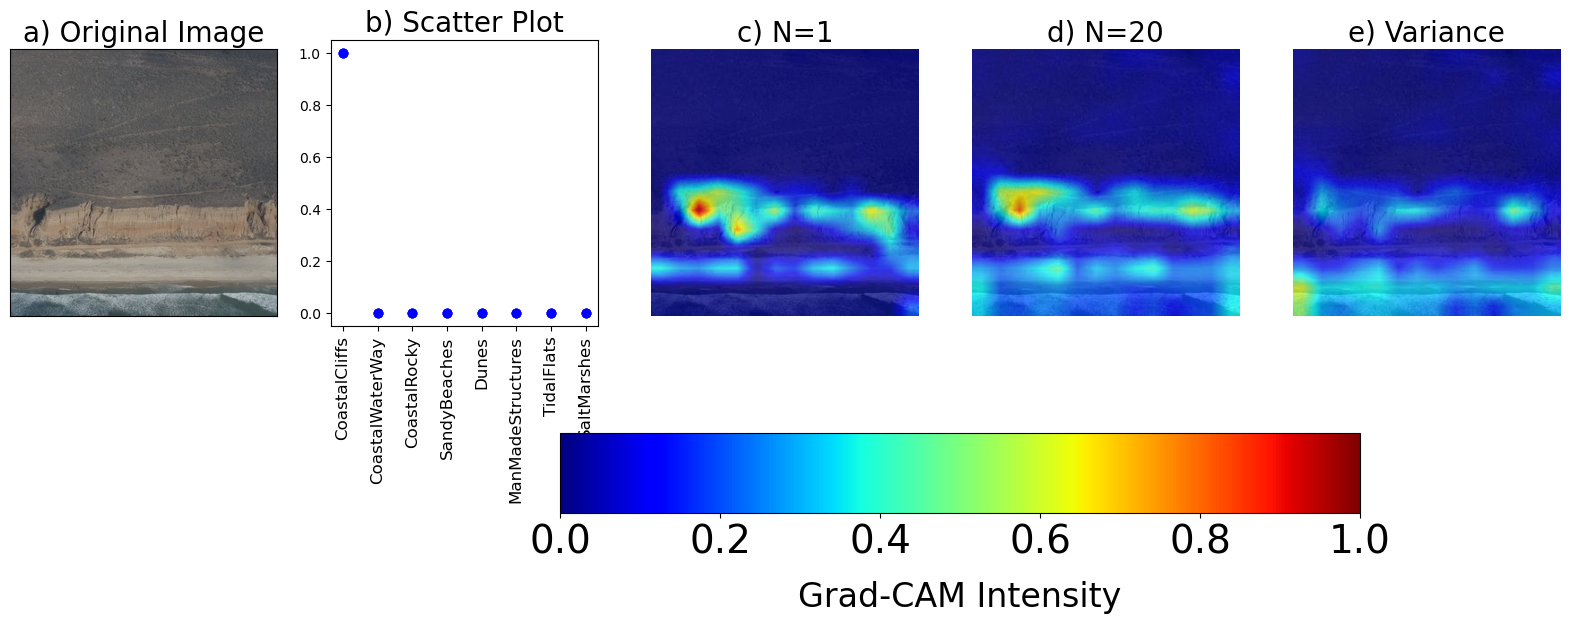

In [2]:
'''This cell is a demonstration of running the Monte Carlo Dropout model checkpoint 20 times on a coastal image. The figure depicts a prediction scatter plot across the 20 run ensemble,
one pass Grad-CAM heatmap overlay, the mean Grad-CAM heatmap overlay across the 20 runs, and finally the element wise variance of the Grad-CAM heatmaps across the 20 run ensemble. 
The model is highly certain about this image, as demonstrated in the low variance depicted in the scatter plot
'''

model =  tf.keras.models.load_model('/data/kraken/coastal_project/coastal_uncertainty/trainers/resnet_mcdropout/models/mcdropout_best/checkpoint81-0.32.h5')
labels_arr=np.array(["CoastalCliffs", "CoastalRocky", "CoastalWaterWay", "Dunes", "ManMadeStructures",
                                    "SaltMarshes", "SandyBeaches","TidalFlats"])

img_size = (224,224)
last_conv_layer_name = "res5a_branch2a"

def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def save_and_display_gradcam(img_path, heatmap, cam_path, alpha=0.7):

    original_img = cv2.imread(img_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    original_img = cv2.resize(original_img, (299,299))

    # Resize the heatmap to match the original image size
    heatmap_resized = cv2.resize(heatmap, (299, 299))

    # Convert the heatmap to a color map (jet colormap)
    heatmap_colormap = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)[..., ::-1]

    # Overlay the heatmap on the original image
    overlay_img = cv2.addWeighted(original_img, 0.4, heatmap_colormap, 0.7, 0.1)
    overlay_img = keras.utils.array_to_img(overlay_img)

    overlay_img.save(cam_path)
    return cam_path, heatmap_resized


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=0): 
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        labels_arr=np.array(["CoastalCliffs", "CoastalRocky", "CoastalWaterWay", "Dunes", "ManMadeStructures",
                         "SaltMarshes", "SandyBeaches","TidalFlats"])
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
       
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

def run_code():
    
    #This is the path to the original image
        
    path_to_file = '/data/kraken/coastal_project/coastal_uncertainty/follow_along_notebook/original_image.jpg'
    
    #These are placeholder images used as Grad-CAM runs across the ensemble
    cam_path_for_var = '/data/kraken/coastal_project/coastal_uncertainty/follow_along_notebook/var.jpg'
    cam_path_for_mean = '/data/kraken/coastal_project/coastal_uncertainty/follow_along_notebook/mean.jpg'
    cam_path_one_pass = '/data/kraken/coastal_project/coastal_uncertainty/follow_along_notebook/1pass.jpg'
    
    img = Image.open(path_to_file)
    img = img.resize((224,224))

    img_path = path_to_file

    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)   #Expand to have batch dimension, for running model

    #Perform one pass of GradCam
    
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    cam_path_1pass_to_plot, heatmap_resize_1pass = save_and_display_gradcam(img_path, heatmap, cam_path_one_pass)
    

    heatmap_list = []
    for i in range (20):
        
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
        heatmap_list.append(heatmap)
        
    # Calculate element-wise mean across all arrays
    mean_heatmap = np.mean(heatmap_list, axis=0)

    # Calculate element-wise variance across all arrays

    element_wise_variance = np.var(heatmap_list, axis=0) 

    log_transformed_data = np.log1p(element_wise_variance) * 5
    var_heatmap = log_transformed_data
    
    grad_cam_var_to_plot, heatmap_resize_var = save_and_display_gradcam(img_path, var_heatmap, cam_path_for_var)
    grad_cam_mean_to_plot, heatmap_resize_mean = save_and_display_gradcam(img_path, mean_heatmap, cam_path_for_mean)

    cam_path_1pass_to_plot = cv2.imread(cam_path_1pass_to_plot)
    mean_1 = cv2.imread(grad_cam_mean_to_plot)
    var_1 = cv2.imread(grad_cam_var_to_plot)

    

    coastal_img_path1 = path_to_file
    coastal_img1 = tf.keras.utils.load_img(coastal_img_path1,
    grayscale=False,
    color_mode='rgb',
    target_size=(224,224),
    interpolation='nearest',
    keep_aspect_ratio=False)

    coastal_array1 = tf.keras.utils.img_to_array(coastal_img1)
    coastal_batch1 = np.expand_dims(coastal_array1, axis=0)

    labels_arr=np.array(["CoastalCliffs", "CoastalRocky", "CoastalWaterWay", "Dunes", "ManMadeStructures",
                                "SaltMarshes", "SandyBeaches","TidalFlats"])

    
    
    y_pred = model.predict(coastal_batch1)
    top_classes = np.argsort(y_pred[0])[::-1][:8]
    x_axis_array = [labels_arr[index] for index in top_classes]
    

    fig, axes = plt.subplots(1, 5, figsize=(20,20))


    ax1 = plt.subplot(1, 5, 1)
    org_img_1 = cv2.imread(img_path)
    ax1.imshow(org_img_1[...,::-1])
    ax1.set_title('a) Original Image', fontsize=20)
    ax1.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

    

    ax2 = plt.subplot(1, 5, 2)
    for i in range(0,20):
        ax2.scatter(range(0,8),model.predict(coastal_batch1)[0][top_classes],c="blue",alpha=0.2)
    ax2.set_xticks(range(0, 8))
    ax2.set_xticklabels(x_axis_array, fontsize=12)
    ax2.tick_params(axis='x', labelrotation=90, labelsize=12)

    ax2.set_aspect(aspect=7.5)
    ax2.set_title('b) Scatter Plot', fontsize=20)
    
    # One Pass Grad-CAM
    ax3 = plt.subplot(1, 5, 3)
    ax3.set_title('c) N=1', fontsize=20)
    ax3.axis('off')
    ax3.imshow(cam_path_1pass_to_plot[..., ::-1])

    # Mean Grad-CAM
    ax4 = plt.subplot(1, 5, 4)
    ax4.set_title('d) N=20', fontsize=20)
    ax4.axis('off')
    ax4.imshow(mean_1[..., ::-1])

    # Variance Grad-CAM
    ax5 = plt.subplot(1, 5, 5)
    ax5.set_title('e) Variance', fontsize=20)
    ax5.axis('off')
    ax5.imshow(var_1[..., ::-1])

    cax = fig.add_axes([0.40, 0.33, 0.4, 0.04])
    sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.set_label('Grad-CAM Intensity', fontsize=24, labelpad=14)
    cbar.ax.tick_params(labelsize=28)
    plt.show()


run_code()


1/1 [==============================] - 0s 57ms/step


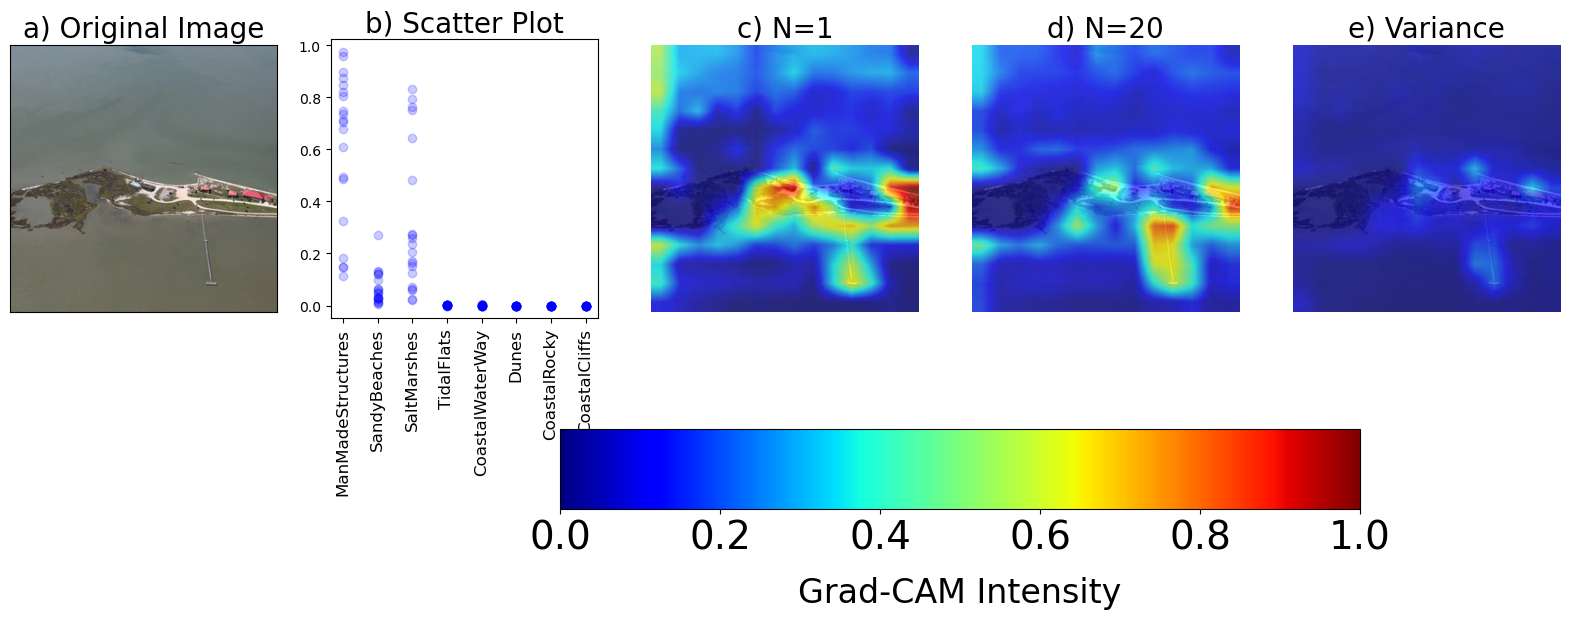

In [3]:
'''This cell is a demonstration of running the Monte Carlo Dropout model checkpoint 20 times on a coastal image. The figure depicts a prediction scatter plot across the 20 run ensemble,
one pass Grad-CAM heatmap overlay, the mean Grad-CAM heatmap overlay across the 20 runs, and finally the element wise variance of the Grad-CAM heatmaps across the 20 run ensemble. 
The model is highly certain about this image, as demonstrated in the low variance depicted in the scatter plot
'''

model =  tf.keras.models.load_model('/data/kraken/coastal_project/coastal_uncertainty/trainers/resnet_mcdropout/models/mcdropout_best/checkpoint81-0.32.h5')
labels_arr=np.array(["CoastalCliffs", "CoastalRocky", "CoastalWaterWay", "Dunes", "ManMadeStructures",
                                    "SaltMarshes", "SandyBeaches","TidalFlats"])

img_size = (224,224)
last_conv_layer_name = "res5a_branch2a"

def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def save_and_display_gradcam(img_path, heatmap, cam_path, alpha=0.7):

    original_img = cv2.imread(img_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    original_img = cv2.resize(original_img, (299,299))

    # Resize the heatmap to match the original image size
    heatmap_resized = cv2.resize(heatmap, (299, 299))

    # Convert the heatmap to a color map (jet colormap)
    heatmap_colormap = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)[..., ::-1]

    # Overlay the heatmap on the original image
    overlay_img = cv2.addWeighted(original_img, 0.4, heatmap_colormap, 0.7, 0.1)
    overlay_img = keras.utils.array_to_img(overlay_img)

    overlay_img.save(cam_path)
    return cam_path, heatmap_resized


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=4): 
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        labels_arr=np.array(["CoastalCliffs", "CoastalRocky", "CoastalWaterWay", "Dunes", "ManMadeStructures",
                         "SaltMarshes", "SandyBeaches","TidalFlats"])
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
            print("PREDITIONS: ", labels_arr[pred_index])
        class_channel = preds[:, pred_index]
        grads = tape.gradient(class_channel, last_conv_layer_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

def run_code():
    

    #This is the path to the original image
    path_to_file = '/data/kraken/coastal_project/coastal_uncertainty/follow_along_notebook/IMG_1338_SecEFG_Sum12_Pt1_resized.jpg'
    

    #These are placeholder images used as Grad-CAM runs across the ensemble
    cam_path_for_var = '/data/kraken/coastal_project/coastal_uncertainty/follow_along_notebook/var.jpg'
    cam_path_for_mean = '/data/kraken/coastal_project/coastal_uncertainty/follow_along_notebook/mean.jpg'
    cam_path_one_pass = '/data/kraken/coastal_project/coastal_uncertainty/follow_along_notebook/1pass.jpg'
    
    img = Image.open(path_to_file)
    img = img.resize((224,224))

    img_path = path_to_file

    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)   #Expand to have batch dimension, for running model

    #Perform one pass of GradCam
    
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    cam_path_1pass_to_plot, heatmap_resize_1pass = save_and_display_gradcam(img_path, heatmap, cam_path_one_pass)
    

    heatmap_list = []
    for i in range (20):
        
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
        heatmap_list.append(heatmap)
        
    # Calculate element-wise mean across all arrays
    mean_heatmap = np.mean(heatmap_list, axis=0)

    # Calculate element-wise variance across all arrays

    element_wise_variance = np.var(heatmap_list, axis=0) 

    log_transformed_data = np.log1p(element_wise_variance) * 5
    var_heatmap = log_transformed_data
    
    grad_cam_var_to_plot, heatmap_resize_var = save_and_display_gradcam(img_path, var_heatmap, cam_path_for_var)
    grad_cam_mean_to_plot, heatmap_resize_mean = save_and_display_gradcam(img_path, mean_heatmap, cam_path_for_mean)

    cam_path_1pass_to_plot = cv2.imread(cam_path_1pass_to_plot)
    mean_1 = cv2.imread(grad_cam_mean_to_plot)
    var_1 = cv2.imread(grad_cam_var_to_plot)

    

    coastal_img_path1 = path_to_file
    coastal_img1 = tf.keras.utils.load_img(coastal_img_path1,
    grayscale=False,
    color_mode='rgb',
    target_size=(224,224),
    interpolation='nearest',
    keep_aspect_ratio=False)

    coastal_array1 = tf.keras.utils.img_to_array(coastal_img1)
    coastal_batch1 = np.expand_dims(coastal_array1, axis=0)

    labels_arr=np.array(["CoastalCliffs", "CoastalRocky", "CoastalWaterWay", "Dunes", "ManMadeStructures",
                                "SaltMarshes", "SandyBeaches","TidalFlats"])

    
    
    y_pred = model.predict(coastal_batch1)
    top_classes = np.argsort(y_pred[0])[::-1][:8]
    x_axis_array = [labels_arr[index] for index in top_classes]
    

    fig, axes = plt.subplots(1, 5, figsize=(20,20))


    ax1 = plt.subplot(1, 5, 1)
    org_img_1 = cv2.imread(img_path)
    ax1.imshow(org_img_1[...,::-1])
    ax1.set_title('a) Original Image', fontsize=20)
    ax1.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

    

    ax2 = plt.subplot(1, 5, 2)
    for i in range(0,20):
        ax2.scatter(range(0,8),model.predict(coastal_batch1)[0][top_classes],c="blue",alpha=0.2)
    ax2.set_xticks(range(0, 8))
    ax2.set_xticklabels(x_axis_array, fontsize=12)
    ax2.tick_params(axis='x', labelrotation=90, labelsize=12)

    ax2.set_aspect(aspect=7.5)
    ax2.set_title('b) Scatter Plot', fontsize=20)
    
    # One Pass Grad-CAM
    ax3 = plt.subplot(1, 5, 3)
    ax3.set_title('c) N=1', fontsize=20)
    ax3.axis('off')
    ax3.imshow(cam_path_1pass_to_plot[..., ::-1])

    # Mean Grad-CAM
    ax4 = plt.subplot(1, 5, 4)
    ax4.set_title('d) N=20', fontsize=20)
    ax4.axis('off')
    ax4.imshow(mean_1[..., ::-1])

    # Variance Grad-CAM
    ax5 = plt.subplot(1, 5, 5)
    ax5.set_title('e) Variance', fontsize=20)
    ax5.axis('off')
    ax5.imshow(var_1[..., ::-1])

    cax = fig.add_axes([0.40, 0.33, 0.4, 0.04])
    sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.set_label('Grad-CAM Intensity', fontsize=24, labelpad=14)
    cbar.ax.tick_params(labelsize=28)
    plt.show()


run_code()


In [4]:
'''The purpose of this file is the evaluate the loaded model and then save the predcition/y_label pairs to a dictionary
in a pickle dump. This pickle file can then be used to more efficiently load evaluation data to produce plots more quickly. 
This cell runes 10 iterations of 20 Monte Carlo samples on the coastal data set using the MC Dropout model checkpoint.
'''

#Only doing one iteration of 2, instead of 10 iteraions of 20 because it takes a while to run in ipynb. Actual pickle file is loaded in next cell.
ITERATIONS = 1
MC_SAMPLES = 2

pickle_save_path = f'/data/kraken/coastal_project/coastal_uncertainty/follow_along_notebook/coastal_mcdrop_{ITERATIONS}_{MC_SAMPLES}_follow_along.pickle'


def evaluate_model_to_pickle(model, test_data):
    print(f"Performing {ITERATIONS} rounds of {MC_SAMPLES} Monte Carlo samples.")
    print('-'*30)
    print('EVALUATING MODEL: ', model)
    results_list = []
    #Run this whole process 10 times 
    for i in range(ITERATIONS):
        print(f'Iteration {i + 1}')
       
        pred_list = []
        y_test = []
        y_test = np.concatenate([y for x,y in test_data], axis=0)
        

        #Run 20 model predictions
        for _ in range(MC_SAMPLES):
            pred_list.append(model.predict(test_data, verbose=1))
            
        predict_probs = np.stack(pred_list, axis=0)

        
        iteration_results = {
        
        'preds': predict_probs,
        'trueLabels': y_test
        }
        results_list.append(iteration_results)  # Append results to the list

    if not os.path.exists(pickle_save_path):
        with open(pickle_save_path, 'wb') as f:
            pickle.dump(results_list, f)
    

model = tf.keras.models.load_model('/data/kraken/coastal_project/coastal_uncertainty/trainers/resnet_mcdropout/models/mcdropout_best/checkpoint81-0.32.h5')
test_data = tf.keras.utils.image_dataset_from_directory(
    '/data/cs4321/HW1/test',
    label_mode='categorical',
    shuffle=False,
    batch_size=1,
    image_size=(224,224))


evaluate_model_to_pickle(model, test_data)

Found 800 files belonging to 8 classes.
Performing 1 rounds of 2 Monte Carlo samples.
------------------------------
EVALUATING MODEL:  <keras.src.engine.functional.Functional object at 0x7f82a0544670>
Iteration 1
800/800 [==============================] - 28s 35ms/step


In [5]:

'''
The purpose of this cell is to print out the metrics that were saved in Pickle format from the above cell that ran the evaluation.
'''
pickle_save_path = '/data/kraken/coastal_project/coastal_uncertainty_aug18/ImageNet-1K-Variational-Embeddings/model_evaluations_into_pickle/resnet_mcdropout/coastal/pickle_dump/mcdropout_10_20.pickle'



def print_uncertainty_metrics():
    acc_cal_combine = []
    #Load from pickle file
    with open(pickle_save_path, 'rb') as f:
        results_list = pickle.load(f)
    aleatoric_list = []
    epistemic_list = []
    total_entropy_list = []

    for index, iteration_results in enumerate(results_list, start=1):
        print(f'Grabbing Dictionary # {index}:')
        
        # Access 'preds' and 'trueLabels' from the current dictionary
        predict_probs = iteration_results['preds']
        y_test_labels = iteration_results['trueLabels']
    
        preds_mc, entropy_mc, nll_mc, pred_std_mc, var, normal_entropy, epistemic_kwon, aleatoric_kwon, epistemic_depeweg, aleatoric_depeweg = BNN_predict(8, predict_probs, y_test_labels,'multi_class')

        y_pred = np.argmax(preds_mc, axis=1)
        y_true = np.argmax(y_test_labels, axis=1)
        accuracy = accuracy_score(y_true, y_pred)
        print('ACCURACY:', accuracy)
        # print('NLL:', nll_mc)
        print('VARIANCE', np.mean(var))
        print('NORMAL_ENTROPY:', np.mean(normal_entropy))
        print('ALEATORIC UNCERTAINTY:', np.mean(aleatoric_depeweg))
        print('EPISTEMIC UNCERTAINTY:', np.mean(epistemic_depeweg))
        aleatoric_list.append(np.mean(aleatoric_depeweg))
        epistemic_list.append(np.mean(epistemic_depeweg))
        total_entropy_list.append(np.mean(entropy_mc))
    print("Aleatoric List: ", aleatoric_list)
    print("Epistemic List: ", epistemic_list)
    print("Total Entropy List: ", total_entropy_list)


        
    df = pd.DataFrame(acc_cal_combine)
    print("total dataframe: ", df)
    mean = df.mean(axis=0) 
    print("total dataframe mean(): ", mean)
    std = df.std(axis=0) 
    print("total dataframe std(): ", std)


print_uncertainty_metrics()

Grabbing Dictionary # 1:
ACCURACY: 0.92
VARIANCE 0.02735985
NORMAL_ENTROPY: 0.05622299
ALEATORIC UNCERTAINTY: 0.1130848
EPISTEMIC UNCERTAINTY: 0.055584177
Grabbing Dictionary # 2:
ACCURACY: 0.91875
VARIANCE 0.026594078
NORMAL_ENTROPY: 0.05534567
ALEATORIC UNCERTAINTY: 0.11157059
EPISTEMIC UNCERTAINTY: 0.05446641
Grabbing Dictionary # 3:
ACCURACY: 0.92
VARIANCE 0.025321934
NORMAL_ENTROPY: 0.055548
ALEATORIC UNCERTAINTY: 0.11411091
EPISTEMIC UNCERTAINTY: 0.052533094
Grabbing Dictionary # 4:
ACCURACY: 0.92125
VARIANCE 0.026621297
NORMAL_ENTROPY: 0.056378122
ALEATORIC UNCERTAINTY: 0.11432835
EPISTEMIC UNCERTAINTY: 0.054806005
Grabbing Dictionary # 5:
ACCURACY: 0.92
VARIANCE 0.025391972
NORMAL_ENTROPY: 0.055795506
ALEATORIC UNCERTAINTY: 0.114525944
EPISTEMIC UNCERTAINTY: 0.052860573
Grabbing Dictionary # 6:
ACCURACY: 0.91875
VARIANCE 0.026428945
NORMAL_ENTROPY: 0.05546998
ALEATORIC UNCERTAINTY: 0.112450466
EPISTEMIC UNCERTAINTY: 0.05395947
Grabbing Dictionary # 7:
ACCURACY: 0.91875
VARIANCE

/data/kraken/coastal_project/coastal_uncertainty_aug18/ImageNet-1K-Variational-Embeddings/follow_along_notebook/model_metrics.py:93: RuntimeWarning: divide by zero encountered in log
  return np.sum(-(true_labels * np.log(model_preds)), axis=1)
/data/kraken/coastal_project/coastal_uncertainty_aug18/ImageNet-1K-Variational-Embeddings/follow_along_notebook/model_metrics.py:93: RuntimeWarning: invalid value encountered in multiply
  return np.sum(-(true_labels * np.log(model_preds)), axis=1)
/data/kraken/coastal_project/coastal_uncertainty_aug18/ImageNet-1K-Variational-Embeddings/follow_along_notebook/model_metrics.py:93: RuntimeWarning: divide by zero encountered in log
  return np.sum(-(true_labels * np.log(model_preds)), axis=1)
/data/kraken/coastal_project/coastal_uncertainty_aug18/ImageNet-1K-Variational-Embeddings/follow_along_notebook/model_metrics.py:93: RuntimeWarning: invalid value encountered in multiply
  return np.sum(-(true_labels * np.log(model_preds)), axis=1)


/data/kraken/coastal_project/coastal_uncertainty_aug18/ImageNet-1K-Variational-Embeddings/follow_along_notebook/model_metrics.py:93: RuntimeWarning: divide by zero encountered in log
  return np.sum(-(true_labels * np.log(model_preds)), axis=1)
/data/kraken/coastal_project/coastal_uncertainty_aug18/ImageNet-1K-Variational-Embeddings/follow_along_notebook/model_metrics.py:93: RuntimeWarning: invalid value encountered in multiply
  return np.sum(-(true_labels * np.log(model_preds)), axis=1)
/data/kraken/coastal_project/coastal_uncertainty_aug18/ImageNet-1K-Variational-Embeddings/follow_along_notebook/model_metrics.py:93: RuntimeWarning: divide by zero encountered in log
  return np.sum(-(true_labels * np.log(model_preds)), axis=1)
/data/kraken/coastal_project/coastal_uncertainty_aug18/ImageNet-1K-Variational-Embeddings/follow_along_notebook/model_metrics.py:93: RuntimeWarning: invalid value encountered in multiply
  return np.sum(-(true_labels * np.log(model_preds)), axis=1)


CLASSIFICATION REPORT AFTER REMOVING 20% MOST UNCERTAIN:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97        84
           1       0.95      0.99      0.97        94
           2       0.99      0.96      0.98        84
           3       1.00      1.00      1.00        85
           4       0.97      0.97      0.97        65
           5       0.92      0.99      0.95        78
           6       1.00      0.93      0.96        73
           7       0.95      0.92      0.93        77

    accuracy                           0.97       640
   macro avg       0.97      0.97      0.97       640
weighted avg       0.97      0.97      0.97       640



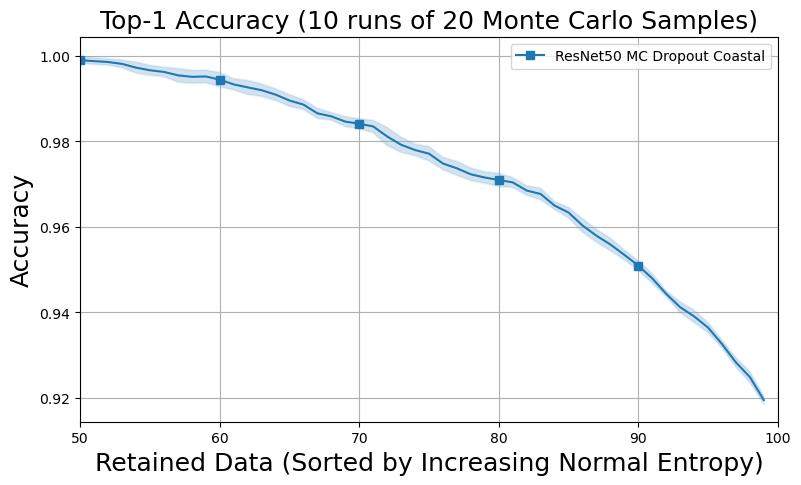

In [6]:
'''
This cell plots a calibration curve for the above model metrics that were generated
'''
import math
from sklearn.metrics import classification_report

#Coastal Pickle Files

pickle_save_path_mcdrop_coastal = '/data/kraken/coastal_project/coastal_uncertainty_aug18/ImageNet-1K-Variational-Embeddings/model_evaluations_into_pickle/resnet_mcdropout/coastal/pickle_dump/mcdropout_10_20.pickle'


def get_metrics_from_pickle(pickle_save_path, imgnet_flag):
    acc_cal_combine = []
    #Load from pickle file
    with open(pickle_save_path, 'rb') as f:
        results_list = pickle.load(f)

    for index, iteration_results in enumerate(results_list, start=1):
       
        
        predict_probs = iteration_results['preds']
        y_test_labels = iteration_results['trueLabels']
        if imgnet_flag == True:
            y_test_labels = np.expand_dims(y_test_labels, 1)
        if imgnet_flag:
            preds_mc, entropy_mc, nll_mc, pred_std_mc, var, normal_entropy, epistemic_kwon, aleatoric_kwon, epistemic_depeweg, aleatoric_depeweg = BNN_predict(1000, predict_probs, y_test_labels,'multi_class')
        else:
            preds_mc, entropy_mc, nll_mc, pred_std_mc, var, normal_entropy, epistemic_kwon, aleatoric_kwon, epistemic_depeweg, aleatoric_depeweg = BNN_predict(8, predict_probs, y_test_labels,'multi_class')

        y_pred = np.argmax(preds_mc, axis=1)
        if imgnet_flag == True:
            y_true = y_test_labels
        else:
            y_true = np.argmax(y_test_labels, axis=1)
        accuracy = accuracy_score(y_true, y_pred)
        

        acc_cal_noe = []
        one_pct = int(y_true.shape[0] * .01) #this is 8

        #this results in more incorrect first --> most correct at the end 
        #high to low entropy
        pred_labels_sort = [v for _,v in sorted(zip(normal_entropy,y_pred), key = lambda x: x[0], reverse=True)]
        true_labels_sort = [v for _,v in sorted(zip(normal_entropy,y_true), key = lambda x: x[0], reverse=True)]
        
        for p in range(100):
            tl = true_labels_sort[p*one_pct:]
            pl = pred_labels_sort[p*one_pct:]
            accuracy=accuracy_score(tl,pl)
            acc_cal_noe.append(accuracy)


        acc_cal_noe.reverse()
        #this is the list of lists
        acc_cal_combine.append(acc_cal_noe)
    cutoff_index = int(0.2 * len(normal_entropy))
    remaining_indices = np.argsort(normal_entropy)[:-cutoff_index]

    y_true_remaining = y_true[remaining_indices]
    y_pred_remaining = y_pred[remaining_indices]
    print('CLASSIFICATION REPORT AFTER REMOVING 20% MOST UNCERTAIN:\n', classification_report(y_true_remaining, y_pred_remaining))

    
        
    df = pd.DataFrame(acc_cal_combine)
    
    mean = df.mean(axis=0) 
   

    index = mean.index
  

    ci = 1.96 * df.std(axis=0) / math.sqrt(10)
    error = ci

    return index, mean, error

def plot_metrics(index, mean, error, label, imgnet_flag):
    lower_plot = mean - error 
    upper_plot = mean + error 

    if imgnet_flag:
        ax.plot(index, mean, marker='s', markevery=10,label=label)
    else:
        ax.plot(index, mean, marker='o', markevery=10,label=label)


    ax.plot(index, lower_plot, color='tab:blue', alpha=0.1)
    ax.plot(index, upper_plot, color='tab:blue', alpha=0.1)
    ax.fill_between(index, lower_plot, upper_plot, alpha=0.2)
    ax.set_xlabel('Retained Data (Sorted by Increasing Normal Entropy)', fontsize = 18)
    ax.set_ylabel('Accuracy', fontsize = 18)     
    ax.grid()
    ax.legend() 
    plt.xlim([50,100])
    plt.title("Top-1 Accuracy (10 runs of 20 Monte Carlo Samples)", fontsize=18)

    
    

#Get the information from the coastal pickle files 

index_mcdrop_coastal, mean_mcdrop_coastal, error_mcdrop_coastal = get_metrics_from_pickle(pickle_save_path_mcdrop_coastal, imgnet_flag=False)
fig, ax = plt.subplots(figsize=(9,5))
plot_metrics(index_mcdrop_coastal, mean_mcdrop_coastal, error_mcdrop_coastal,label="ResNet50 MC Dropout Coastal", imgnet_flag=True)


plt.savefig(f"/data/kraken/coastal_project/coastal_uncertainty/follow_along_notebook/plot_calibrations2.png")


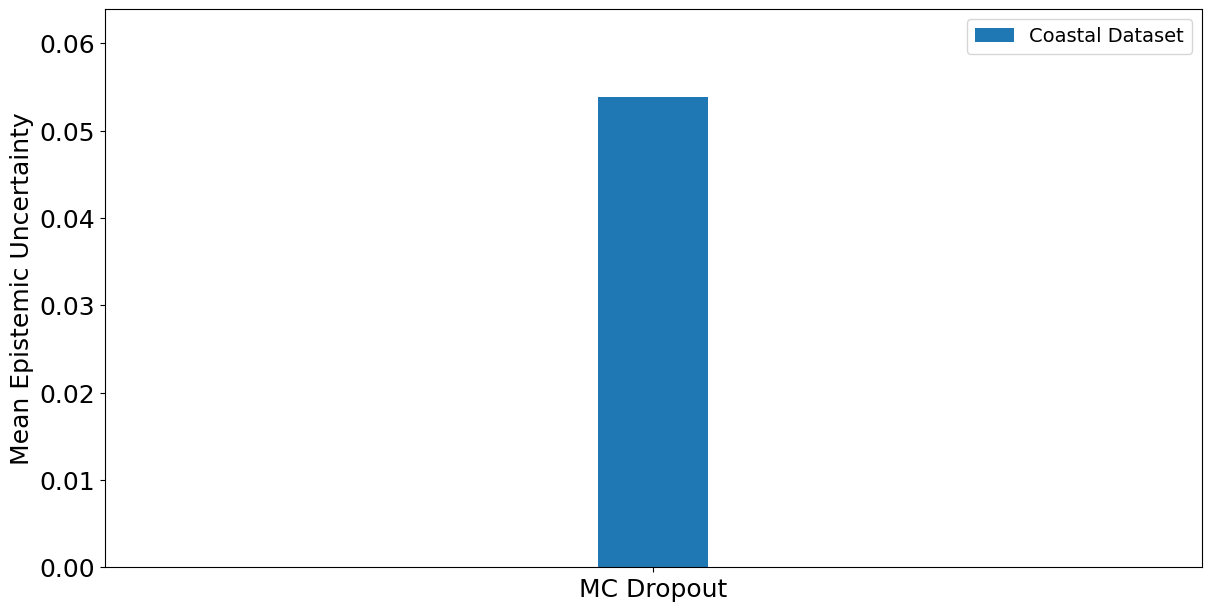

In [12]:
import matplotlib.pyplot as plt
import numpy as np


#ORIGINAL COASTAL
#MCDROPOUT
#These values are copied from the "Print Uncertainty Metrics" function two cells above
epistemic_uncertainty_original_mcdrop = [0.055584177, 0.05446641, 0.052533094, 0.054806005, 0.052860573, 0.05395947, 0.05300803, 0.05458558, 0.054274574, 0.052653052]
mean_epistemic_original_mcdrop = sum(epistemic_uncertainty_original_mcdrop) / len(epistemic_uncertainty_original_mcdrop)



species = ["MC Dropout"]
batch_1 = {
    'Coastal Dataset': mean_epistemic_original_mcdrop
}

x = np.arange(len(species))  
width = 0.1

fig, ax = plt.subplots(layout='constrained')

for i, (attribute, measurement) in enumerate(batch_1.items()):
    ax.bar(x[i], measurement, width, label=attribute)
ax.set_xlim(-0.5, 0.5)  # Provides padding on both sides of the bar
ax.set_ylim(0, mean_epistemic_original_mcdrop + 0.01)  # Provides space above the bar

# Labels and ticks
ax.set_ylabel("Mean Epistemic Uncertainty", fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(species, fontsize=18)
ax.tick_params(axis='y', which='both', labelsize=18)
ax.legend(loc='upper right', fontsize=14)

# Show the plot
plt.show()












In [13]:
'''
This cell shows calculating Expected Calibration Error, using the pickle evaluation file for MC Dropout over 10 rounds of 20 on the coastal dataset
'''


#Coastal Pickle Files


#Code from: https://colab.research.google.com/github/majapavlo/medium/blob/main/ece_medium.ipynb
def expected_calibration_error(samples, true_labels, M=15):
    # uniform binning approach with M number of bins
    bin_boundaries = np.linspace(0, 1, M + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    # get max probability per sample i
    confidences = np.max(samples, axis=1)
    # get predictions from confidences (positional in this case)
    predicted_label = np.argmax(samples, axis=1)

    # get a boolean list of correct/false predictions
    accuracies = predicted_label==true_labels

    ece = np.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # determine if sample is in bin m (between bin lower & upper)
        in_bin = np.logical_and(confidences > bin_lower.item(), confidences <= bin_upper.item())
        # can calculate the empirical probability of a sample falling into bin m: (|Bm|/n)
        prob_in_bin = in_bin.mean()

        if prob_in_bin.item() > 0:
            # get the accuracy of bin m: acc(Bm)
            accuracy_in_bin = accuracies[in_bin].mean()
            # get the average confidence of bin m: conf(Bm)
            avg_confidence_in_bin = confidences[in_bin].mean()
            # calculate |acc(Bm) - conf(Bm)| * (|Bm|/n) for bin m and add to the total ECE
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prob_in_bin
    return ece



def get_ece_from_pickle(pickle_save_path, imgnet_flag, name):
    '''
    This function iterates through 10 rounds of 20 MC samples in each pickle file passed in. ECE is calculated for each of the 20 samples, 10 times. Means
    are printed out at the bottom of the function. 
    '''
    
    #Load from pickle file
    with open(pickle_save_path, 'rb') as f:
        results_list = pickle.load(f)
        ece_mean_list = []
        accuracy_mean_list = []

    for index, iteration_results in enumerate(results_list, start=1):
        #Looping through ten rounds

        ece_list = []
        accuracy_list = []
        
        print(f'Grabbing Dictionary # {index}:')    
        
        predict_probs = iteration_results['preds']
        y_test_labels = iteration_results['trueLabels'] #This is the same across all 10 rounds (it's just the true labels)

        #Loop through the 20 MC samples across the 20 run ensemble

        for i in range (20):
            probs = predict_probs[i]
            
            if imgnet_flag:
               
                y_true_ece = (y_test_labels.flatten()).astype(int) #Special formatting due to imagenet array structure
                ece = expected_calibration_error(probs, y_true_ece)
                y_pred = np.argmax(probs, axis=1)
                accuracy = accuracy_score(y_test_labels, y_pred)

            else:
                y_test = np.argmax(y_test_labels, axis=1) #gets the index (1,2,3,4,etc.) from [0,0,0,1,...]
                ece = expected_calibration_error(probs, y_test)
                y_pred = np.argmax(probs, axis=1)
                accuracy = accuracy_score(np.argmax(y_test_labels, axis=1), y_pred)

            ece_list.append(ece)
            accuracy_list.append(accuracy)

        ece_mean = np.mean(np.array(ece_list)) #Take the mean across the 20
        print(f"Mean ECE across 1 run of 20 samples for {name}: {ece_mean}")

        accuracy_mean = np.mean(np.array(accuracy_list)) #Take the mean across the 20
        print(f"Mean Accuracy across 1 run of 20 samples for {name}: {accuracy_mean}")

        ece_mean_list.append(ece_mean)
        accuracy_mean_list.append(accuracy_mean)

    ece_df = pd.DataFrame(ece_mean_list)
    ece_std = ece_df.std(axis=0) 

    accuracy_df = pd.DataFrame(accuracy_mean_list)
    accuracy_std = accuracy_df.std(axis=0)

    accuracy_mean = accuracy_df.mean(axis=0) 
    print("***Accuracy Total Mean: ", accuracy_mean)

    ece_mean = ece_df.mean(axis=0)
    print("***ECE Total Mean: ", ece_mean)

    accuracy_mean = accuracy_df.mean(axis=0) 

    print("***Accuracy Total Std: ", accuracy_std)
    print("***ECE Total Std: ", ece_std)

    accuracy_ci = 1.96 * accuracy_std / math.sqrt(10)
    ece_ci = 1.96 * ece_std / math.sqrt(10)

    print("***Accuracy Total Confidence Interval: ", accuracy_ci)
    print("***ECE Total Confidence Interval: ", ece_ci)


#Get the information from the coastal pickle files 
get_ece_from_pickle(pickle_save_path_mcdrop_coastal, imgnet_flag=False, name = "MC Dropout Coastal")






Grabbing Dictionary # 1:
Mean ECE across 1 run of 20 samples for MC Dropout Coastal: 0.05559458442497998
Mean Accuracy across 1 run of 20 samples for MC Dropout Coastal: 0.9081875
Grabbing Dictionary # 2:
Mean ECE across 1 run of 20 samples for MC Dropout Coastal: 0.056876913930289444
Mean Accuracy across 1 run of 20 samples for MC Dropout Coastal: 0.909
Grabbing Dictionary # 3:
Mean ECE across 1 run of 20 samples for MC Dropout Coastal: 0.05674262335617095
Mean Accuracy across 1 run of 20 samples for MC Dropout Coastal: 0.9078124999999998
Grabbing Dictionary # 4:
Mean ECE across 1 run of 20 samples for MC Dropout Coastal: 0.05558957462385298
Mean Accuracy across 1 run of 20 samples for MC Dropout Coastal: 0.907625
Grabbing Dictionary # 5:
Mean ECE across 1 run of 20 samples for MC Dropout Coastal: 0.057417193214409044
Mean Accuracy across 1 run of 20 samples for MC Dropout Coastal: 0.9065
Grabbing Dictionary # 6:
Mean ECE across 1 run of 20 samples for MC Dropout Coastal: 0.0567923271